# TMDB Box Office Prediction
>
> https://www.kaggle.com/c/tmdb-box-office-prediction

---



In [305]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast

## Load Data

In [306]:
# Directory containing the csv files
dir_path = 'data'

train = pd.read_csv(f"{dir_path}/train.csv")
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1600195,en,Lolita,Anna (Marceau) is a wife and mother who has an...,NaN,...,9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Deadfall,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5391990d0e0a260fb5001629', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


## Exploratory Data Analysis

In [307]:
# Check for missing values
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Numerical Features

Plotting some of the simple features helps us find a common ground.

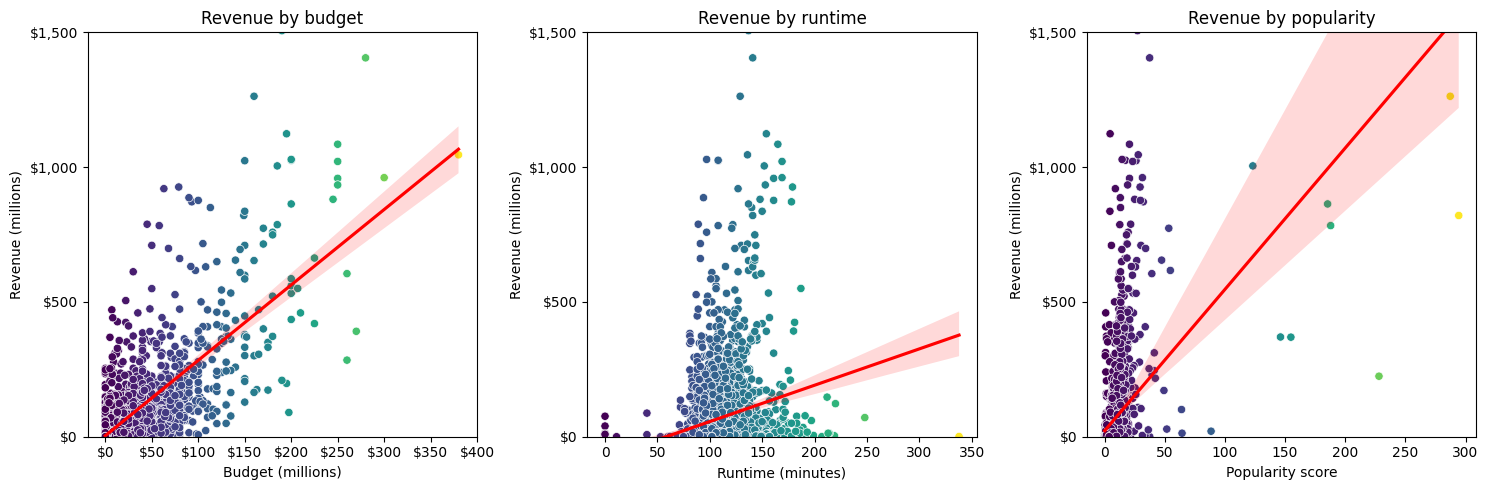

In [308]:
# Budget
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=train.iloc[:3000], x='budget', y='revenue', hue='budget', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='budget', y='revenue', scatter=False, color='red')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000, 400000000], ['$0', '$50', '$100', '$150', '$200', '$250', '$300', '$350', '$400'])
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by budget')
plt.xlabel('Budget (millions)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Runtime
plt.subplot(1, 3, 2)
sns.scatterplot(data=train.iloc[:3000], x='runtime', y='revenue', hue='runtime', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='runtime', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Popularity
plt.subplot(1, 3, 3)
sns.scatterplot(data=train.iloc[:3000], x='popularity', y='revenue', hue='popularity', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='popularity', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by popularity')
plt.xlabel('Popularity score')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

plt.tight_layout()
plt.show()

Let's take a look at the distribution of the revenue.

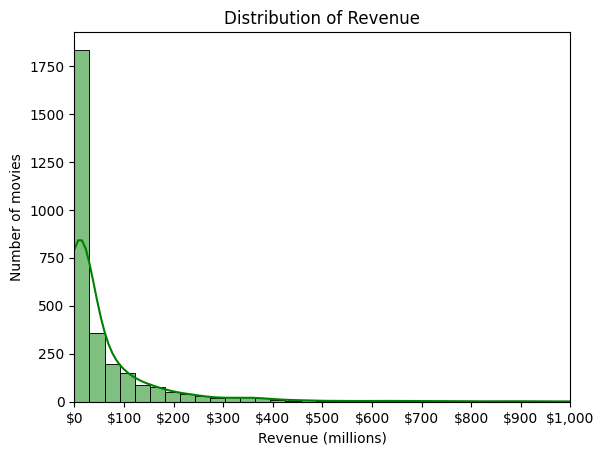

In [309]:
sns.histplot(train.revenue, bins=50, kde=True, color='green')
plt.xlabel('Revenue (millions)')
plt.xticks([0, 100000000, 200000000, 300000000, 400000000, 500000000, 600000000, 700000000, 800000000, 900000000, 1000000000], ['$0', '$100', '$200', '$300', '$400', '$500', '$600', '$700', '$800', '$900', '$1,000'])
plt.xlim(0, 1000000000)
plt.ylabel('Number of movies')
plt.title('Distribution of Revenue')
plt.show()

In [310]:
train.revenue.describe().apply(lambda x: f'{x:,.0f}')

count            3,000
mean        66,725,852
std        137,532,326
min                  1
25%          2,379,808
50%         16,807,068
75%         68,919,204
max      1,519,557,910
Name: revenue, dtype: object

The distribution of the revenue is heavily skewed to the right. Normalization of the datapoints with log can help increase the performance of the model.

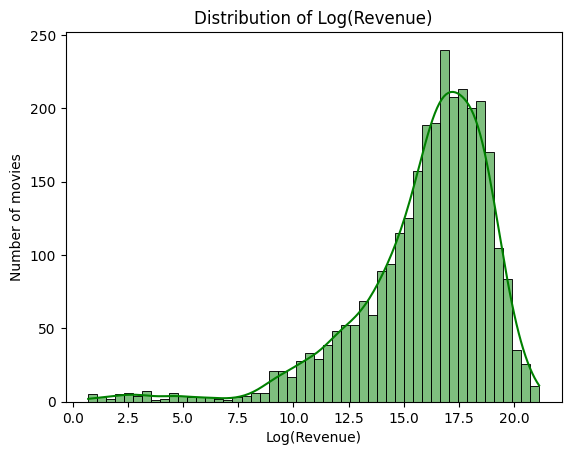

In [311]:
train['log_revenue'] = np.log1p(train.revenue)
sns.histplot(train.log_revenue, bins=50, kde=True, color='green')
plt.xlabel('Log(Revenue)')
plt.ylabel('Number of movies')
plt.title('Distribution of Log(Revenue)')
plt.show()

Taking the logarithm of the revenue lead to a more normal distribution, stabilized variance, and provide coefficients that are easier to interpret in multiplicative terms. These advantages can improve the accuracy and interpretability of the revenue forecasting model.

### Feature Engineering

#### Collection

In [312]:
# Extract collection names
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)[0]['name'] if pd.notna(x) and ast.literal_eval(x) else None)

# Group by collection name, count occurrences, and sort
collection_counts = train['collection_name'].value_counts().reset_index()
collection_counts.columns = ['collection_name', 'movie_count']

# Filter out collections with no name and display the head
collection_counts = collection_counts[collection_counts['collection_name'].notna()]
collection_counts.head(10)

,collection_name,movie_count
0,James Bond Collection,16
1,Friday the 13th Collection,7
2,The Pink Panther (Original) Collection,6
3,Police Academy Collection,5
4,Pokémon Collection,5
5,Resident Evil Collection,4
6,Rambo Collection,4
7,Ice Age Collection,4
8,Alien Collection,4
9,Paranormal Activity Collection,4


Now for the test data.

Now we change the `belongs_to_collection` feature into something easier to handle like a simple bool.

In [313]:
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if pd.notna(x) else 0)
train[['collection_name', 'belongs_to_collection']].head()

,collection_name,belongs_to_collection
0,Hot Tub Time Machine Collection,1
1,The Princess Diaries Collection,1
2,None,0
3,None,0
4,None,0


Let's plot the results.

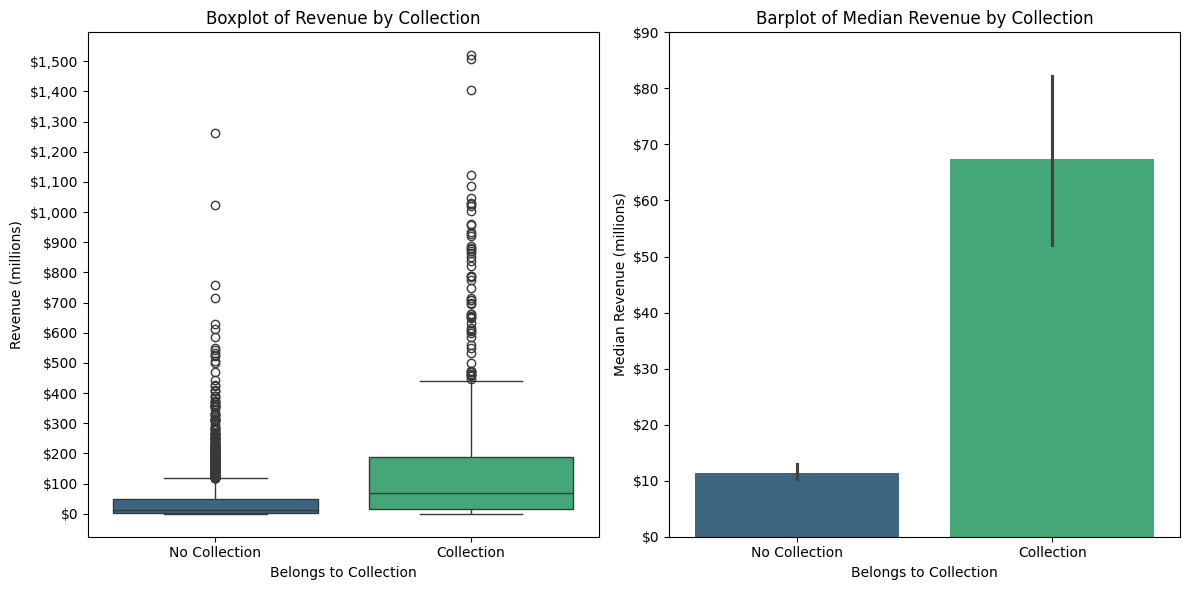

In [314]:
# Create subplots
plt.figure(figsize=(12, 6))

# Boxplot for revenue by belongs_to_collection
plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='belongs_to_collection', y='revenue', hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 100000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 100000000)])
plt.title('Boxplot of Revenue by Collection')
plt.legend().remove()

# Barplot for median revenue by belongs_to_collection
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='belongs_to_collection', y='revenue', estimator=np.median, hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Median Revenue (millions)')
plt.yticks(np.arange(0, 100000000, 10000000), [f'${x//1000000:,}' for x in np.arange(0, 100000000, 10000000)])
plt.title('Barplot of Median Revenue by Collection')
plt.legend().remove()

plt.tight_layout()
plt.show()

So we can see here that movies which belong to a collection seem to get higher revenues.

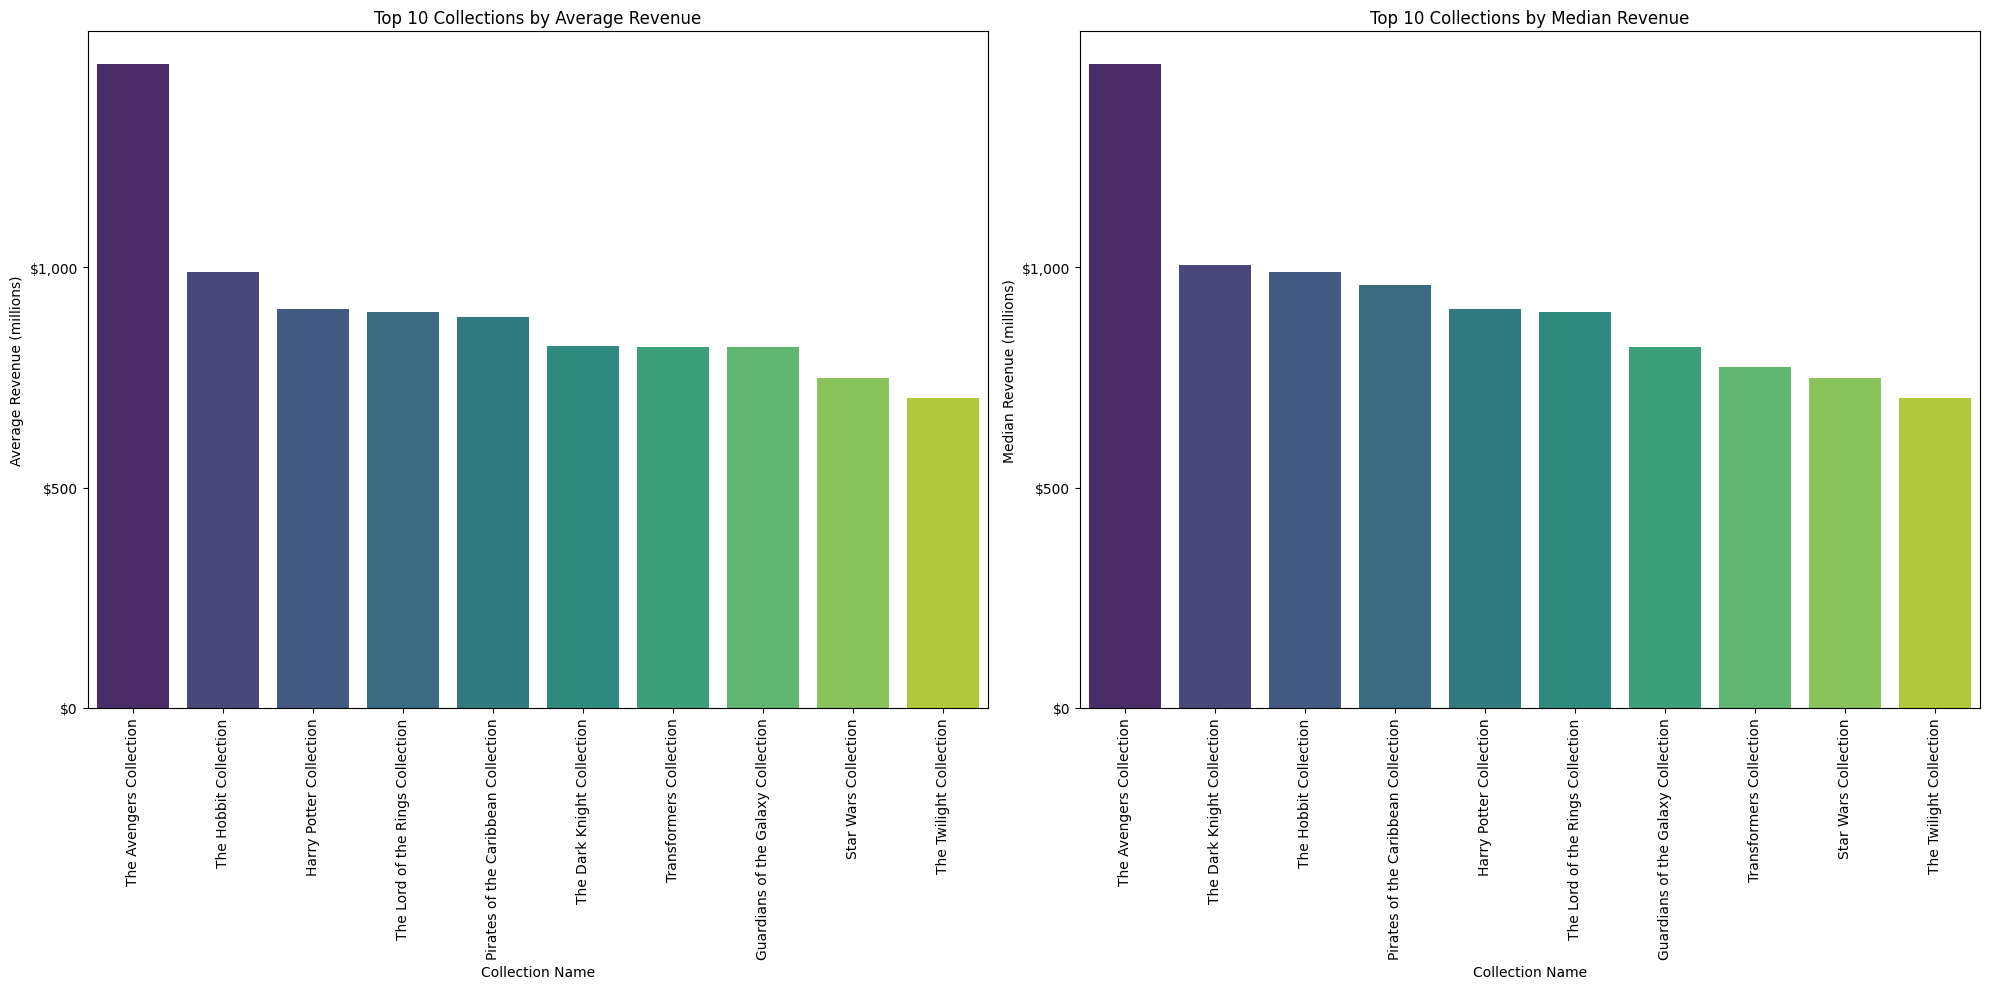

In [315]:
# Define valid collections
valid_collections = collection_counts[collection_counts['movie_count'] > 1]['collection_name']

# Group by collection_name and calculate the median revenue for valid collections
collection_median_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].median().reset_index()

# Sort the collections by median revenue in descending order and select the top 10
collection_median_revenue = collection_median_revenue.sort_values(by='revenue', ascending=False).head(10)

# Calculate the average revenue for valid collections
collection_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].mean().reset_index()

# Sort the collections by average revenue in descending order and select the top 10
collection_revenue = collection_revenue.sort_values(by='revenue', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(20, 10))

# Average revenue plot
plt.subplot(1, 2, 1)
sns.barplot(data=collection_revenue, y='revenue', x='collection_name', hue='collection_name', palette='viridis')
plt.ylabel('Average Revenue (millions)')
plt.xlabel('Collection Name')
plt.title('Top 10 Collections by Average Revenue')
plt.yticks(np.arange(0, collection_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_revenue['revenue'].max(), step=500000000)])
plt.xticks(rotation=90)

# Median revenue plot
plt.subplot(1, 2, 2)
sns.barplot(data=collection_median_revenue, y='revenue', x='collection_name', hue='collection_name', palette='viridis')
plt.ylabel('Median Revenue (millions)')
plt.xlabel('Collection Name')
plt.title('Top 10 Collections by Median Revenue')
plt.yticks(np.arange(0, collection_median_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_median_revenue['revenue'].max(), step=500000000)])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Here we can see the collections with the highest revenues by average and median.

#### Production Company

For the production company we are going to use the first mentioned entry and assume that this is the main production company.

In [316]:
# Function to extract the first production company name and id
def extract_main_production_company_info(companies):
    try:
        company = ast.literal_eval(companies)[0]
        return company['name'], company['id']
    except (IndexError, ValueError, TypeError):
        return None, None

# Apply the function to the 'production_companies' column
train['main_prod_comp'], train['main_prod_comp_id'] = zip(*train['production_companies'].apply(extract_main_production_company_info))

# Display the first few rows to verify
train[['production_companies', 'main_prod_comp', 'main_prod_comp_id']].head()

,production_companies,main_prod_comp,main_prod_comp_id
0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",Paramount Pictures,4.0
1,"[{'name': 'Walt Disney Pictures', 'id': 2}]",Walt Disney Pictures,2.0
2,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...",Bold Films,2266.0
3,NaN,None,NaN
4,NaN,None,NaN


In [317]:
main_prod_comp_counts = train.groupby(['main_prod_comp', 'main_prod_comp_id']).size().reset_index(name='counts')
main_prod_comp_counts = main_prod_comp_counts.sort_values(by='counts', ascending=False)
main_prod_comp_counts.head(10)

,main_prod_comp,main_prod_comp_id,counts
977,Universal Pictures,33.0,167
706,Paramount Pictures,4.0,158
966,Twentieth Century Fox Film Corporation,306.0,122
210,Columbia Pictures,5.0,90
1006,Warner Bros.,6194.0,70
649,New Line Cinema,12.0,69
1004,Walt Disney Pictures,2.0,62
961,TriStar Pictures,559.0,44
211,Columbia Pictures Corporation,441.0,44
974,United Artists,60.0,41


It seems like within the data there are some variations of the same company name. 

For example:
- Columbia Pictures, 90
- Columbia Pictures Corporation, 44

In order to avoid treating the same entity as different ones and create more accurate results, they can be grouped into a single one.

In [318]:
# Dictionary of canonical company names
canonical_companies_mapping = {
    'Warner Bros.': 'Warner Bros',
    'Warner Bros. Pictures': 'Warner Bros',
    'Universal Pictures': 'Universal Pictures',
    'Universal Studios': 'Universal Pictures',
    'Twentieth Century Fox': 'Twentieth Century Fox',
    'Twentieth Century Fox Film Corporation':'Twentieth Century Fox',
    'Columbia Pictures': 'Columbia Pictures',
    'Columbia Pictures Corporation': 'Columbia Pictures',
    'Walt Disney Pictures': 'Walt Disney Pictures',
    'Walt Disney': 'Walt Disney Pictures',
    'Walt Disney Productions': 'Walt Disney Pictures',
    'Canal Plus': 'Canal Plus',
    'Canal+': 'Canal Plus',
    'StudioCanal': 'Canal Plus',
    'Studio Canal': 'Canal Plus',
    'Lionsgate': 'Lionsgate',
    'Lions Gate Films': 'Lionsgate',
    'LionsGate': 'Lionsgate',
    'Dreamworks Pictures': 'Dreamworks Pictures',
    'DreamWorks Pictures': 'Dreamworks Pictures',
    'DreamWorks SKG': 'Dreamworks Pictures',
    'DreamWorks Animation': 'Dreamworks Pictures',
    'Metro-Goldwyn-Mayer (MGM)': 'Metro Goldwyn Mayer',
}

# Correct the main_prod_comp column using the canonical_companies_mapping dictionary
train['main_prod_comp'] = train['main_prod_comp'].replace(canonical_companies_mapping)

# Count the occurrences of each main production company
main_prod_comp_counts = train['main_prod_comp'].value_counts().reset_index()
main_prod_comp_counts.columns = ['main_prod_comp', 'count']

# Display the list
main_prod_comp_counts.head(10)

,main_prod_comp,count
0,Universal Pictures,175
1,Paramount Pictures,158
2,Columbia Pictures,134
3,Twentieth Century Fox,123
4,Warner Bros,74
5,Walt Disney Pictures,69
6,New Line Cinema,69
7,TriStar Pictures,44
8,United Artists,41
9,Metro Goldwyn Mayer,40


In order to turn this feature into something manageable, we will use production companies with more than 40 movies. The rest is going to be treated as smaller companies and they will get the value `Other` assigned.

In [319]:
# Create a dictionary to map production companies to their counts
prod_comp_counts_dict = main_prod_comp_counts.set_index('main_prod_comp')['count'].to_dict()

# Create the binary column 'major_prod_comp'
train['major_prod_comp'] = train['main_prod_comp'].apply(lambda x: 1 if prod_comp_counts_dict.get(x, 0) > 60 else 0)

# Display the first few rows to verify
train[['main_prod_comp', 'major_prod_comp']].head()

# Update main_prod_comp to 'Other' for samples with major_prod_comp equal to 0
train.loc[train['major_prod_comp'] == 0, 'main_prod_comp'] = 'Other'

# Display the first few rows to verify
train[['main_prod_comp', 'major_prod_comp']].head()

,main_prod_comp,major_prod_comp
0,Paramount Pictures,1
1,Walt Disney Pictures,1
2,Other,0
3,Other,0
4,Other,0


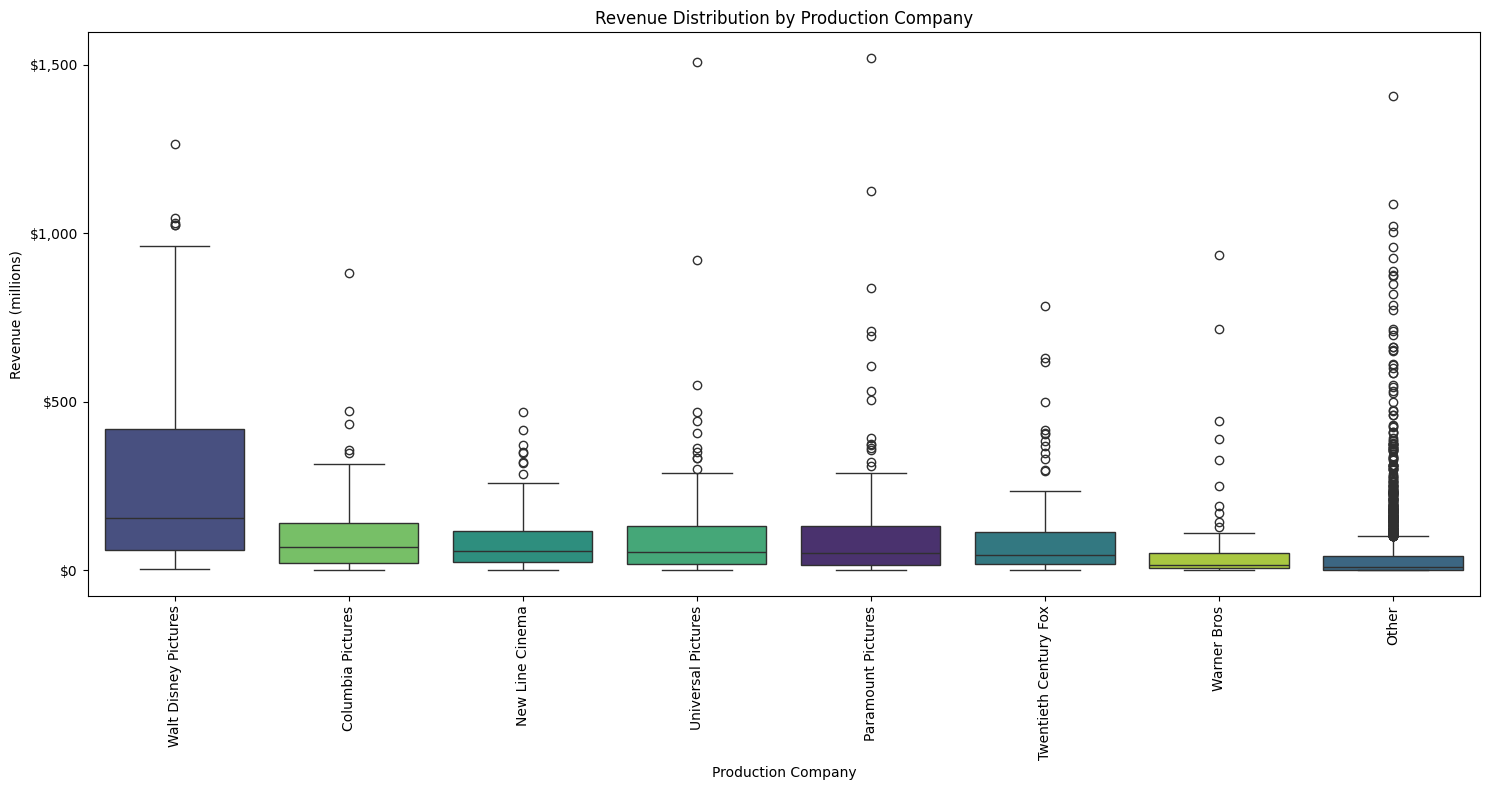

In [320]:
# Calculate the median revenue for each production company
prod_comp_revenue = train.groupby('main_prod_comp')['revenue'].median().reset_index()

# Sort the production companies by median revenue in descending order
prod_comp_revenue = prod_comp_revenue.sort_values(by='revenue', ascending=False)

# Plot the data
plt.figure(figsize=(15, 8))
sns.boxplot(data=train, y='revenue', x='main_prod_comp', hue='main_prod_comp', order=prod_comp_revenue['main_prod_comp'], palette='viridis')
plt.ylabel('Revenue (millions)')
plt.xlabel('Production Company')
plt.title('Revenue Distribution by Production Company')
plt.yticks(np.arange(0, 1600000000, step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, 1600000000, step=500000000)])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

For most of the *top* production companies the average revenue is much higher than for the others.

In the next step I will use one-hot encoding in order to make this information useable for the training of the model.

In [322]:
# Get the unique production companies
unique_prod_comps = train['main_prod_comp'].unique()

# Create binary columns for each production company
for comp in unique_prod_comps:
    column_name = f'prod_comp_{comp.replace(" ", "_").replace(".", "").replace("-", "_")}'
    train[column_name] = train['main_prod_comp'].apply(lambda x: 1 if x == comp else 0)

# Display the first few rows to verify
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,main_prod_comp_id,major_prod_comp,prod_comp_Paramount_Pictures,prod_comp_Walt_Disney_Pictures,prod_comp_Other,prod_comp_Twentieth_Century_Fox,prod_comp_New_Line_Cinema,prod_comp_Universal_Pictures,prod_comp_Columbia_Pictures,prod_comp_Warner_Bros
0,1,1,14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,4.0,1,1,0,0,0,0,0,0,0
1,2,1,40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,2.0,1,0,1,0,0,0,0,0,0
2,3,0,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,2266.0,0,0,0,1,0,0,0,0,0
3,4,0,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,NaN,0,0,0,1,0,0,0,0,0
4,5,0,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,NaN,0,0,0,1,0,0,0,0,0


In [330]:
train.drop(columns=['production_companies'], inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               3000 non-null   int64  
 1   belongs_to_collection            3000 non-null   int64  
 2   budget                           3000 non-null   int64  
 3   genres                           2993 non-null   object 
 4   homepage                         946 non-null    object 
 5   imdb_id                          3000 non-null   object 
 6   original_language                3000 non-null   object 
 7   original_title                   3000 non-null   object 
 8   overview                         2992 non-null   object 
 9   popularity                       3000 non-null   float64
 10  poster_path                      2999 non-null   object 
 11  production_countries             2945 non-null   object 
 12  release_date        

#### Language

#### Release Date

#### Gender of Cast

#### Genre

Looking at the dataset 

In [ ]:
# Count the number of genres per movie
train['genre_count'] = train['genres'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

# Count the number of movies for each genre count
genre_count_distribution = train['genre_count'].value_counts().sort_index()

# Display the distribution
genre_count_distribution

In [ ]:
# Calculate the median and 0.8 quantile of genre_count
median_genre_count = train['genre_count'].median()
quantile_80_genre_count = train['genre_count'].quantile(0.80)

# Plot the histogram
sns.histplot(train['genre_count'], bins=range(0, train['genre_count'].max() + 1), kde=False, color='lightgreen')

# Add a vertical line for the median
plt.axvline(median_genre_count, color='red', linestyle='--', label=f'Median: {median_genre_count}')

# Add a vertical line for the 0.8 quantile
plt.axvline(quantile_80_genre_count, color='blue', linestyle='--', label=f'80% Quantile: {quantile_80_genre_count}')

# Add labels and title
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.title('Histogram of Number of Genres per Movie')
plt.legend()

# Show the plot
plt.show()

80% of the samples have either 1, 2 or 3 genres. This might lead to the conclusion that the most significant genres in a list are the first 3. Let's find out which one is the most significant one.

In [ ]:
# Function to extract genres
def extract_genres(genres, index):
    try:
        return ast.literal_eval(genres)[index]['name']
    except (IndexError, ValueError, TypeError):
        return None

# Create new columns for the first three genres
train['genre_1'] = train['genres'].apply(lambda x: extract_genres(x, 0))
train['genre_2'] = train['genres'].apply(lambda x: extract_genres(x, 1))
train['genre_3'] = train['genres'].apply(lambda x: extract_genres(x, 2))

# Display the first few rows to verify
train[['genres', 'genre_1', 'genre_2', 'genre_3']].head()

In [ ]:
# Concatenate the genre columns
all_genres = pd.concat([train['genre_1'], train['genre_2'], train['genre_3']])

# Count the occurrences of each genre
genre_appearances = all_genres.value_counts()

# Display the most occurring genres
print(genre_appearances.head(20))

The genres that appear the most are Drama, Comedy, Action and Thriller. Let's see if they are also the ones with the highest revenue.

In [ ]:
# Calculate the median revenue for each genre
genre_1_median_revenue = train.groupby('genre_1')['revenue'].median().reset_index()
genre_2_median_revenue = train.groupby('genre_2')['revenue'].median().reset_index()
genre_3_median_revenue = train.groupby('genre_3')['revenue'].median().reset_index()

# Combine the three genre median revenue DataFrames
genre_1_median_revenue['genre'] = 'Genre 1'
genre_2_median_revenue['genre'] = 'Genre 2'
genre_3_median_revenue['genre'] = 'Genre 3'

combined_genre_revenue = pd.concat([
    genre_1_median_revenue.rename(columns={'genre_1': 'genre_name'}),
    genre_2_median_revenue.rename(columns={'genre_2': 'genre_name'}),
    genre_3_median_revenue.rename(columns={'genre_3': 'genre_name'})
])

# Ensure the genres are ordered according to genre_appearances
combined_genre_revenue['genre_name'] = pd.Categorical(
    combined_genre_revenue['genre_name'],
    categories=genre_appearances.index,
    ordered=True
)

# Plot the combined data
plt.figure(figsize=(15, 10))
sns.barplot(data=combined_genre_revenue, y='revenue', x='genre_name', hue='genre', palette='viridis')
plt.ylabel('Median Revenue')
plt.xlabel('Genre')
plt.title('Median Revenue by Genre')
plt.yticks(np.arange(0, 110000000, 10000000), [f'${x//1000000:,}' for x in np.arange(0, 110000000, 10000000)])
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the ratio of revenue by budget, handling division by zero
train['revenue_budget_ratio'] = np.where(train['budget'] == 0, np.nan, train['revenue'] / train['budget'])

# Display the first few rows to verify
train[['title', 'revenue', 'budget', 'revenue_budget_ratio']].head()

In [ ]:
# Calculate the median revenue_budget_ratio for each genre
genre_1_median_ratio = train.groupby('genre_1')['revenue_budget_ratio'].median().reset_index()
genre_2_median_ratio = train.groupby('genre_2')['revenue_budget_ratio'].median().reset_index()
genre_3_median_ratio = train.groupby('genre_3')['revenue_budget_ratio'].median().reset_index()

# Combine the three genre median revenue_budget_ratio DataFrames
genre_1_median_ratio['genre'] = 'Genre 1'
genre_2_median_ratio['genre'] = 'Genre 2'
genre_3_median_ratio['genre'] = 'Genre 3'

combined_genre_ratio = pd.concat([
    genre_1_median_ratio.rename(columns={'genre_1': 'genre_name'}),
    genre_2_median_ratio.rename(columns={'genre_2': 'genre_name'}),
    genre_3_median_ratio.rename(columns={'genre_3': 'genre_name'})
])

# Ensure the genres are ordered according to genre_appearances
combined_genre_ratio['genre_name'] = pd.Categorical(
    combined_genre_ratio['genre_name'],
    categories=genre_appearances.index,
    ordered=True
)

# Plot the combined data
plt.figure(figsize=(15, 10))
sns.barplot(data=combined_genre_ratio, y='revenue_budget_ratio', x='genre_name', hue='genre', palette='viridis')
plt.ylabel('Median Revenue/Budget Ratio')
plt.xlabel('Genre')
plt.title('Median Revenue/Budget Ratio by Genre')
plt.tight_layout()
plt.show()

Based on this graph one could think that

In [ ]:
# Calculate the median log revenue for each genre
genre_1_median_log_revenue = train.groupby('genre_1')['log_revenue'].median().reset_index()
genre_2_median_log_revenue = train.groupby('genre_2')['log_revenue'].median().reset_index()
genre_3_median_log_revenue = train.groupby('genre_3')['log_revenue'].median().reset_index()

# Combine the three genre median log_revenue DataFrames
genre_1_median_log_revenue['genre'] = 'Genre 1'
genre_2_median_log_revenue['genre'] = 'Genre 2'
genre_3_median_log_revenue['genre'] = 'Genre 3'

combined_genre_log_revenue = pd.concat([
    genre_1_median_log_revenue.rename(columns={'genre_1': 'genre_name'}),
    genre_2_median_log_revenue.rename(columns={'genre_2': 'genre_name'}),
    genre_3_median_log_revenue.rename(columns={'genre_3': 'genre_name'})
])

# Ensure the genres are ordered according to genre_appearances
combined_genre_log_revenue['genre_name'] = pd.Categorical(
    combined_genre_log_revenue['genre_name'],
    categories=genre_appearances.index,
    ordered=True
)

# Plot the combined data
plt.figure(figsize=(15, 10))
sns.barplot(data=combined_genre_log_revenue, y='log_revenue', x='genre_name', hue='genre', palette='viridis')
plt.ylabel('Median Log Revenue')
plt.xlabel('Genre')
plt.title('Median Log Revenue by Genre')
plt.yticks(np.arange(0, 26, 5), [f'{x}' for x in np.arange(0, 26, 5)])
plt.tight_layout()
plt.show()


For the moment we will keep all three different genre columns. We can identify later on in the training how significant each one is.

# Linear Regression

In [328]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
prod_comps = [
    'prod_comp_Paramount_Pictures',
    'prod_comp_Walt_Disney_Pictures',
    'prod_comp_Other',
    'prod_comp_Twentieth_Century_Fox',
    'prod_comp_New_Line_Cinema',
    'prod_comp_Universal_Pictures',
    'prod_comp_Columbia_Pictures',
    'prod_comp_Warner_Bros'
]

features = ['budget', 'runtime', 'popularity', 'belongs_to_collection']
features.extend(prod_comps)

X = train[features]

# Fill missing values with the median of each column
X = X.fillna(X.median())

y = train['revenue']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = np.mean(np.abs(y_test - y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")
print(f"Adjusted R^2 Score: {adjusted_r2}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Absolute Error: 46415070.41924072
Mean Squared Error: 6274270134796551.0
Root Mean Squared Error: 79210290.5864923
R^2 Score: 0.6040010903353726
Adjusted R^2 Score: 0.5986437206443067
Mean Absolute Percentage Error: 6453966.008081628


**MAE:** The average of the absolute differences between predicted and actual values.

**MSE:** The average of the squared differences between predicted and actual values.

**RMSE:** The square root of the MSE, bringing the error metric back to the original units of `Y`.

**R^2:** The proportion of the variance in the dependent variable that is predictable from the independent variables.

**Adjusted R^2:** Adjusts the standard R² value to penalize the inclusion of non-informative predictors.

**MAPE:** The average of the absolute percentage differences between predicted and actual values.

In [325]:
# Calculate the median and mean revenue
median_revenue = train['revenue'].median()
mean_revenue = train['revenue'].mean()

# Define a threshold for unusually low revenue (e.g., less than 10% of the median revenue)
threshold = 0.1 * median_revenue

# Filter the dataset for unusually low revenue values
low_revenue_movies = train[train['revenue'] < threshold]

# Display the results
print(f"Median Revenue: {median_revenue}")
print(f"Mean Revenue: {mean_revenue}")
print(f"Threshold for low revenue: {threshold}")
print(f"Number of movies with unusually low revenue: {len(low_revenue_movies)}")
low_revenue_movies[['title', 'budget', 'revenue']]

Median Revenue: 16807068.0
Mean Revenue: 66725851.88866667
Threshold for low revenue: 1680706.8
Number of movies with unusually low revenue: 666


,title,budget,revenue
15,Skinning,500000,198
17,The Invisible Woman,0,1234254
22,V/H/S,0,100345
23,InSight,0,17011
33,ABCs of Death 2,0,7171
...,...,...,...
2988,Ten,0,105656
2989,The Trumpet Of The Swan,0,100202
2992,The Thief of Bagdad,1135654,1213880
2995,Chasers,0,1596687


In [326]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest model
rf_model = RandomForestRegressor(max_depth=8, n_estimators=100)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and get predictions
y_pred = cross_val_predict(rf_model, X, y, cv=kf)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 5910046924109320.0
Root Mean Squared Error: 76876829.56593177
R^2 Score: 0.6874452237447453
